# Word Vectors

En este trabajo, utilizaremos **embeddings** para resolver un problema de clasificación de texto. Los embeddings, representaciones distribuidas y vectoriales de elementos, son un concepto muy común en el mundo del deep learning. Los **word vectors** que hemos visto en clase son una representación en forma de embedding de las palabras.

Para realizar este trabajo y sacarle el máximo partido, se recomienda ver los siguientes vídeos de clase:

*   Clasificación de texto con Word Vectors.
*   Análisis de overfitting con un modelo bag of words.
*   Clasificación de texto con RNN

Vamos a utilizar el dataset **"Reuters newswire topics classification"**, disponible desde Keras de manera similar al dataset de IMDB ([ver documentación](https://keras.io/datasets/#reuters-newswire-topics-classification)).

---

Se pide:

Entrenar un modelo **utilizando embeddings** que consiga un **65% de accuracy en test (55% si usamos RNNs)**, mostrando el entrenamiento y el resultado final.
 
Tenemos varias opciones para entrenar modelos con embeddings. El alumno puede explorar más de una pero es suficiente con conseguir un modelo que alcance la accuracy requerida:

*   Utilizar una **media de embeddings** al estilo de lo visto en el vídeo *Clasificación de texto con Word Vectors*
*   Utilizar una **CNN** sobre una secuencia de word vectors. Aquí necesitamos cambiar un poco la idea de convolución para actuar sobre sequencias de vectores. Keras incluye una [Convolución en 1D](https://keras.io/layers/convolutional/#conv1d) que puede ser utilizada en este caso, con un ejemplo de uso en la documentación. Una forma de hacer funcionar este esquema sería utilizar la convolución en 1D + max pooling.
*  Utilizar una **RNN** sobre una secuencia de word vectors, al estilo de lo visto en el vídeo *Clasificación de texto con RNN*. Para este problema es un poco complicado conseguir un buen modelo con RNNs, y además es más difícil experimentar ya que las redes recurrentes son modelos lentos de entrenar. Por eso, es suficiente con alcanzar un 55% de accuracy si optamos por utilizar un modelo de este estilo. Un buen consejo es emplear una red recurrente bidireccional como se ve en el vídeo *Clasificación de texto con RNN*.



---

Dos hiperparámetros importantes a elegir en el modelo son la **longitud de las secuencias de texto** y el **tamaño del vocabulario** para los embeddings. Podéis experimentar con ambos, o utilizar los mismos que se usan en los vídeos. Nótese que, al cortar todas las secuencias para que tengan el mismo tamaño, podríamos estar perdiendo mucho texto si elegimos un tamaño de secuencia demasiado pequeño. Igualmente, si las hacemos muy largas necesitaremos más tiempo para entrenar nuestros modelos. Una buena idea consiste en explorar los datos para ver cómo suelen ser de largos los textos y encontrar un buen trade-off para el tamaño de al secuencia.



---

Los embeddings que hemos visto en los vídeos se entrenan junto al modelo.  Una técnica frecuente es inicializar estos embeddings con word-vectors pre-entrenados en un gran corpus de texto, como hemos visto en clase. Esto puede ayudar ya que nuestro modelo empieza con unos embeddings que ya encapsulan significado. Si bien no es necesario para esta práctica, podéis ver cómo usar esta técnica [en el siguiente tutorial](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).




## Inicializamos el entorno

In [116]:
## Tu código
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.12.0-rc2


## Descargamos el dataset

Dataset of 11,228 newswires from Reuters, labeled over 46 topics. As with the IMDB dataset, each wire is encoded as a sequence of word indexes (same conventions).

In [117]:
from keras.datasets import reuters
max_words=10000
(x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=max_words,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,# Para shuffle
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)

In [118]:
print("Training entries: {}, labels: {}".format(len(x_train), len(y_train)))
print("Test entries: {}, labels: {}".format(len(x_test), len(y_test)))

Training entries: 8982, labels: 8982
Test entries: 2246, labels: 2246


En este caso se ha metido un valor por defecto "test_split=0.2" para separar el conjunto en un 80% de datos de entrenamiento y un 20% de datos de test. Como en la lección magistral, cada elemento del dataset es un vector de índices (Siendo cada índice una palabra), por lo que tenemos que descargarnos el diccionario de vectores que nos dirá a que palabra se corresponde cada índice..

### Descargamos el diccionario de índices de palabras

In [119]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
print(type(word_index))
print(word_index[max(word_index)])

<class 'dict'>
23568


Los primeros indices están reservados para estructuras y separación de textos:

In [120]:
# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

### Comprobamos los datos descargados

In [121]:
#Imprimimos el primer valor de train
print(x_train[0])

#Imprimimos sus características
print("Num Classes", max(y_train)+1)

#Imprimimos una palabra de ejemplo que se corresponda con un indice de x_train
print(list(word_index.keys())[list(word_index.values()).index(4)])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
Num Classes 46
the


### Funcion decodificacion de noticias

In [122]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [123]:
decode_review(x_train[3])

"<START> the farmers home administration the u s agriculture department's farm lending arm could lose about seven billion dlrs in outstanding principal on its severely <UNK> borrowers or about one fourth of its farm loan portfolio the general accounting office gao said in remarks prepared for delivery to the senate agriculture committee brian crowley senior associate director of gao also said that a preliminary analysis of proposed changes in <UNK> financial eligibility standards indicated as many as one half of <UNK> borrowers who received new loans from the agency in 1986 would be <UNK> under the proposed system the agency has proposed evaluating <UNK> credit using a variety of financial ratios instead of relying solely on <UNK> ability senate agriculture committee chairman patrick leahy d vt <UNK> the proposed eligibility changes telling <UNK> administrator <UNK> clark at a hearing that they would mark a dramatic shift in the agency's purpose away from being farmers' lender of last 

### Preprocesado de datos de train y test

Como las noticias tienen longitudes distintas, hay que definir un tamaño X para todas. Las que sean mayores, se recortarán, y las que sean menores, se rellenarán con el token de padding.

In [124]:
print(len(x_train[0]))
print(len(x_test[0]))
print(word_index["<PAD>"])

87
145
0


In [125]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [126]:
print(len(x_train[0]))
print(len(x_test[0]))

256
256


In [127]:
num_classes=max(y_train)+1
print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (8982, 46)
y_test shape: (2246, 46)


## Definimos un modelo de entrenamiento embedded

In [128]:
from __future__ import print_function

import numpy as np
import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer

### Parametros del modelo

In [129]:
batch_size = 32
epochs = 40

#### Split de datos de entrada

In [130]:
x_val = x_train[6982:]
x_train_partial = x_train[:6982]

y_val = y_train[6982:]
y_train_partial = y_train[:6982]

### Definicion del modelo

In [131]:
def embedding_model():
    print('Building model...')
    model = Sequential()
    model.add(Embedding(max_words, 16))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(16, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    model.summary()
    return model

In [132]:
model = embedding_model()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_7 ( (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 46)                782       
Total params: 161,054
Trainable params: 161,054
Non-trainable params: 0
_________________________________________________________________


In [133]:
history = model.fit(x_train_partial, y_train_partial,
                    batch_size=batch_size,
                    epochs=150,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 6982 samples, validate on 2000 samples
Epoch 1/150
6982/6982 [==============================] - 1s 93us/step - loss: 3.1343 - acc: 0.2557 - val_loss: 2.2914 - val_acc: 0.3465
Epoch 2/150
6982/6982 [==============================] - 0s 55us/step - loss: 2.4029 - acc: 0.3394 - val_loss: 2.1933 - val_acc: 0.3595
Epoch 3/150
6982/6982 [==============================] - 0s 54us/step - loss: 2.2800 - acc: 0.3725 - val_loss: 2.0796 - val_acc: 0.3790
Epoch 4/150
6982/6982 [==============================] - 0s 54us/step - loss: 2.1625 - acc: 0.3910 - val_loss: 1.9644 - val_acc: 0.3985
Epoch 5/150
6982/6982 [==============================] - 0s 55us/step - loss: 2.0497 - acc: 0.4242 - val_loss: 1.8661 - val_acc: 0.4555
Epoch 6/150
6982/6982 [==============================] - 0s 55us/step - loss: 1.9702 - acc: 0.4513 - val_loss: 1.7987 - val_acc: 0.4960
Epoch 7/150
6982/6982 [==============================] - 0s 55us/step - loss: 1.9053 - acc: 0.4704 - val_loss: 1.7451 - val_acc: 0.5560


6982/6982 [==============================] - 0s 54us/step - loss: 0.9635 - acc: 0.7229 - val_loss: 1.4442 - val_acc: 0.7085
Epoch 61/150
6982/6982 [==============================] - 0s 54us/step - loss: 0.9661 - acc: 0.7262 - val_loss: 1.4381 - val_acc: 0.7105
Epoch 62/150
6982/6982 [==============================] - 0s 53us/step - loss: 0.9550 - acc: 0.7226 - val_loss: 1.4605 - val_acc: 0.7075
Epoch 63/150
6982/6982 [==============================] - 0s 53us/step - loss: 0.9368 - acc: 0.7274 - val_loss: 1.4482 - val_acc: 0.7040
Epoch 64/150
6982/6982 [==============================] - 0s 54us/step - loss: 0.9349 - acc: 0.7300 - val_loss: 1.4206 - val_acc: 0.7135
Epoch 65/150
6982/6982 [==============================] - 0s 53us/step - loss: 0.9237 - acc: 0.7279 - val_loss: 1.4345 - val_acc: 0.7120
Epoch 66/150
6982/6982 [==============================] - 0s 53us/step - loss: 0.9267 - acc: 0.7312 - val_loss: 1.4396 - val_acc: 0.7110
Epoch 67/150
6982/6982 [==============================

Epoch 120/150
6982/6982 [==============================] - 0s 59us/step - loss: 0.7055 - acc: 0.7731 - val_loss: 1.9324 - val_acc: 0.7135
Epoch 121/150
6982/6982 [==============================] - 0s 59us/step - loss: 0.7190 - acc: 0.7789 - val_loss: 1.9468 - val_acc: 0.7145
Epoch 122/150
6982/6982 [==============================] - 0s 58us/step - loss: 0.6984 - acc: 0.7819 - val_loss: 1.9739 - val_acc: 0.7125
Epoch 123/150
6982/6982 [==============================] - 0s 54us/step - loss: 0.7120 - acc: 0.7753 - val_loss: 1.9538 - val_acc: 0.7195
Epoch 124/150
6982/6982 [==============================] - 0s 58us/step - loss: 0.6879 - acc: 0.7804 - val_loss: 1.9820 - val_acc: 0.7170
Epoch 125/150
6982/6982 [==============================] - 0s 58us/step - loss: 0.6954 - acc: 0.7794 - val_loss: 1.9542 - val_acc: 0.7155
Epoch 126/150
6982/6982 [==============================] - 0s 54us/step - loss: 0.7072 - acc: 0.7736 - val_loss: 1.9713 - val_acc: 0.7110
Epoch 127/150
6982/6982 [=========

### Evaluacion del modelo

In [134]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 21us/step
Test loss score: 2.3630392160780813
Test accuracy: 0.7034728406585972


In [135]:
history_dict = history.history

In [136]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [137]:
history_dict['loss']

[3.1342890110988395,
 2.4028508804548574,
 2.280016968974887,
 2.1624674357919904,
 2.0497156019300964,
 1.970174854377456,
 1.905318948574443,
 1.862001951770023,
 1.8291007211713044,
 1.7906456535233362,
 1.7560322307577383,
 1.7179838048459055,
 1.6825097266598508,
 1.6521418256494658,
 1.6248885422851116,
 1.5922854171377032,
 1.5653109858487473,
 1.5414998245526097,
 1.5303616870340868,
 1.5075352570963465,
 1.4948959828993886,
 1.4699124049675973,
 1.4519584210681833,
 1.4158938010966187,
 1.4022498194995838,
 1.3673882043931929,
 1.351057445719535,
 1.3251266460369528,
 1.3251213920864258,
 1.3065721252114135,
 1.2903972473502399,
 1.263417149641834,
 1.2560377897402852,
 1.2328895588584972,
 1.2143397875209143,
 1.2060209890212346,
 1.1968877449038375,
 1.1898159195379008,
 1.1736573200449838,
 1.1438841475726063,
 1.142193489329448,
 1.1348644298661645,
 1.1142362802495112,
 1.1029821948023726,
 1.0910698709328104,
 1.0915027754298599,
 1.0770559846347534,
 1.0618778525314643,

### Gráficas del modelo

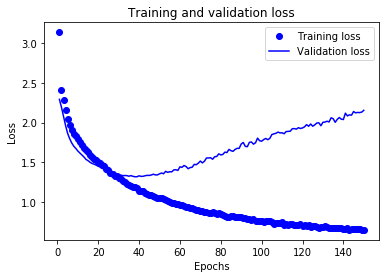

In [138]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

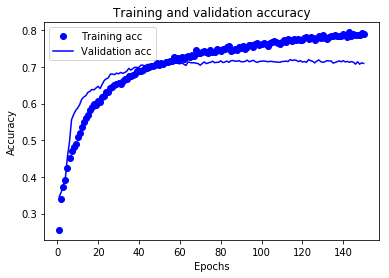

In [139]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Conclusiones

A la vista de los resultados, el modelo empieza a caer en el overfitting a partir de los 40 epochs. En dicho valor el accuracy deja de crecer y las pérdidas se incrementan.
El modelo propuesto obtiene un 0,7 de accuracy por lo que se puede considerar válido de cara a lo requerido en la práctica.